In [1]:

%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt

def plot_radius_time_sweep(dataframe, vertical_axis, value, fig, ax, **kwargs):
    """
    expects a dataframe with the following columns
    
    start_time : numpy.datetime64
    radius : float64 or int
    
    ::params::
    ----------------------------------
    dataframe : pandas.dataframe
    value : dataframe column header to be plotted as color map
    kwargs : any values that can be used with matplotlib.pyplot.pcolormesh
    
    ::dependencies::
    ----------------------------------
    matplotlib
    numpy
    pandas
    
    ::notes::
    ----------------------------------
    this could probably, and should probably, be generalized for any axis
    case. or at least such that the vertical axis is specified by the user
    """
    # TODO: provide option to for time axis to be "years before" instead of explicit date
    zi = dataframe.pivot(index='start_time', columns=vertical_axis, values=value)
    xi_label = [np.datetime64(z, 'Y').astype(str) for z in zi.index]
    xi = np.arange(len(xi_label))
    yi = zi.columns
    xi, yi = np.meshgrid(xi, yi)
    zi = np.ma.masked_invalid(zi).transpose()
    cbar = ax.pcolormesh(xi, yi, zi, **kwargs)
#     fig.colorbar(cbar, label=str(value))
    
#     xi_ticks = [i for i, j in  enumerate(replace_unique_items(xi_label)) if j is not None]
#     xi_labels = [j for i, j in  enumerate(replace_unique_items(xi_label)) if j is not None]
    
#     ax.set_xticks(xi_ticks)
#     ax.set_xticklabels(xi_labels, rotation=90)
    
    ax.set_ylabel(vertical_axis)
    
    return fig, ax, cbar

In [2]:
noto_hanto = {'coordinates':(136.686000, 37.220667), 'time':'2007-03-25 00:41:57.909996'
              , 'tz':'UTC', 'magnitude':6.9, 'name':'Noto Hanto', 'focal_mech':[34, 40, 108]}
western_tottori = {'coordinates':(133.349, 35.274167), 'time':'2000-10-06 04:30:17.940011'
                   , 'tz':'UTC', 'magnitude':6.7, 'name':'Western Tottori', 'focal_mech':[331, 83, 1]}
sugura_bay = {'coordinates':(138.499333, 34.786167), 'time':'2009-08-10 20:07:05.740017'
              , 'tz':'UTC', 'magnitude':6.5, 'name':'Suruga Bay', 'focal_mech':[88, 51, 63]}
iwaki = {'coordinates':(140.672667, 36.945667), 'time':'2011-04-11 08:16:12.020008'
         , 'tz':'UTC', 'magnitude':6.6, 'name':'Iwaki', 'focal_mech':[139    ,53   ,-75]}
iwate_miyage = {'coordinates':(140.880667, 39.029833), 'time':'2008-06-13 23:43:45.359992'
                , 'tz':'UTC', 'magnitude':6.8, 'name':'Iwate Miyage', 'focal_mech':[17  ,  42  , 87]}
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00'
            , 'tz':'UTC', 'magnitude':7.0, 'name':'Kumamoto', 'focal_mech':[128  , 71 , -14]}
tohoku = {'coordinates':(142.861000, 38.103500), 'time':'2011-03-11 05:46:18.119983'
          , 'tz':'UTC', 'magnitude':9.0, 'name':'Tohoku-oki'}
eqs = {'suruga-bay':sugura_bay, 'iwaki':iwaki, 'iwate-miyage':iwate_miyage
      ,'kumamoto':kumamoto, 'noto-hanto':noto_hanto, 'western-tottori':western_tottori}


In [3]:

catalog = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [4]:
# true_b['kumamoto'].start_time.tail(1).values.astype('datetime64[Y]').astype(int)[0]-20

In [5]:
bdf_sugura = pd.read_csv('b_sugura_bay_4_13_2017.csv')
bdf_iwaki = pd.read_csv('b_iwaki_04_13_2017.csv')
bdf_iwate = pd.read_csv('b_iwate_miyage_4_13_2017.csv')
bdf_kumamoto = pd.read_csv('b_kumamoto_4_13_2017.csv')
bdf_noto_hanto = pd.read_csv('b_noto_hanto_4_13_2017.csv')
bdf_tottori = pd.read_csv('b_western_tottori_4_13_2017.csv')

avg_b = {'suruga-bay':bdf_sugura, 'iwaki':bdf_iwaki, 'iwate-miyage':bdf_iwate
         ,'kumamoto':bdf_kumamoto, 'noto-hanto':bdf_noto_hanto, 'western-tottori':bdf_tottori}

btrue_sugura = pd.read_csv('b_true_sugura_bay_4_13_2017.csv')
btrue_iwaki = pd.read_csv('b_true_iwaki_04_13_2017.csv')
btrue_iwate = pd.read_csv('b_true_iwate_miyage_4_13_2017.csv')
btrue_kumamoto = pd.read_csv('b_true_kumamoto_4_13_2017.csv')
btrue_noto_hanto = pd.read_csv('b_true_noto_hanto_4_13_2017.csv')
btrue_tottori = pd.read_csv('b_true_western_tottori_4_13_2017.csv')

true_b = {'suruga-bay':btrue_sugura, 'iwaki':btrue_iwaki, 'iwate-miyage':btrue_iwate
         ,'kumamoto':btrue_kumamoto, 'noto-hanto':btrue_noto_hanto, 'western-tottori':btrue_tottori}

In [6]:

for eq in true_b:
    avg = true_b[eq][true_b[eq].b.between(0, 2)].b.mean()
    std = avg_b[eq][avg_b[eq].b_avg.between(0, 2)].b_avg.std()
    distance = 1.0
    vmin = avg - distance * std
    vmax = avg + distance * std
    n = avg_b[eq][avg_b[eq].b_avg.between(0,2)].n_avg.mean()
    stderr = std / np.sqrt(n)
    
    eqs[eq]['average b-value'] = avg
    eqs[eq]['stderr'] = stderr

In [7]:
eqs

{'iwaki': {'average b-value': 0.8891179320574548,
  'coordinates': (140.672667, 36.945667),
  'focal_mech': [139, 53, -75],
  'magnitude': 6.6,
  'name': 'Iwaki',
  'stderr': 0.026936447938834301,
  'time': '2011-04-11 08:16:12.020008',
  'tz': 'UTC'},
 'iwate-miyage': {'average b-value': 0.7709893389841758,
  'coordinates': (140.880667, 39.029833),
  'focal_mech': [17, 42, 87],
  'magnitude': 6.8,
  'name': 'Iwate Miyage',
  'stderr': 0.0036784930379599487,
  'time': '2008-06-13 23:43:45.359992',
  'tz': 'UTC'},
 'kumamoto': {'average b-value': 0.8005890681759927,
  'coordinates': (130.763, 32.7545),
  'focal_mech': [128, 71, -14],
  'magnitude': 7.0,
  'name': 'Kumamoto',
  'stderr': 0.0011644278998544778,
  'time': '2016-04-14 12:26:00',
  'tz': 'UTC'},
 'noto-hanto': {'average b-value': 0.63134738712171,
  'coordinates': (136.686, 37.220667),
  'focal_mech': [34, 40, 108],
  'magnitude': 6.9,
  'name': 'Noto Hanto',
  'stderr': 0.030790557314586537,
  'time': '2007-03-25 00:41:57.9

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


[array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5])]

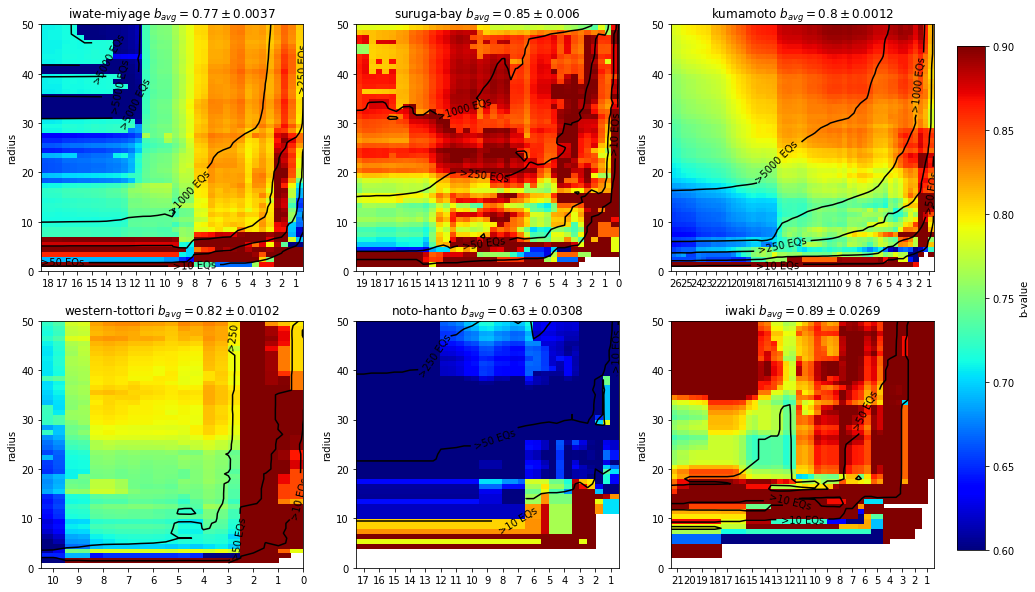

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
# ((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33)) = ax

ax = [item for sublist in ax for item in sublist]

for eq, axis in zip(true_b, ax):
    

    cbar = plot_radius_time_sweep(dataframe=true_b[eq], vertical_axis='radius'
                                     , value='b',vmin=0.6, vmax=0.9, cmap='jet', fig=fig, ax=axis)
    axis.set_title(eq + ' $b_{avg}$'+'$={b}\pm{err}$'.format(b=round(eqs[eq]['average b-value'], 2),
                                              err=round(eqs[eq]['stderr'], 4)))
    
    years_int = true_b[eq].start_time.tail(1).values.astype('datetime64[Y]').astype(int)[0]-20
    
    years = np.arange(1, years_int*2+2, 2)
    axis.set_xticks(years)
    axis.set_xticklabels((years/2).astype(int)[::-1])
    
    zi = true_b[eq].pivot(index='start_time', columns='radius', values='n')
    xi_label = [np.datetime64(z, 'Y') for z in zi.index]
    xi = np.arange(len(xi_label))
    yi = zi.columns
    xi, yi = np.meshgrid(xi, yi)

    zi = np.ma.masked_invalid(zi).transpose()

    levels = [10, 50, 250, 1000, 5000]
    cs = axis.contour(xi,yi,zi, levels, colors='black')#, locator=ticker.LogLocator())

    cs.levels = ['>10 EQs', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

    axis.clabel(cs, cs.levels, inline=True)
    axis.set_ylim(0,50)

cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
fig.colorbar(cbar[2], cax=cbar_ax, label='b-value')
[years/2][::-1]

In [9]:
catalog.head()

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err
timestamp,,,,,,,,,,,,,
1989-12-31 15:12:50.899987,139.963333,37.326667,1989.998997,12.0,31.0,1.9,6.4,15.0,12.0,50.900002,1.752955,3.7,NaN
1989-12-31 15:26:39.499997,137.620000,34.813333,1989.999023,12.0,31.0,1.4,28.0,15.0,26.0,39.499997,1.062217,1.3,NaN
1989-12-31 18:11:02.199987,142.820000,41.473333,1989.999336,12.0,31.0,2.7,35.0,18.0,11.0,2.200001,6.021544,NaN,NaN
1989-12-31 19:25:57.299991,137.648333,35.233333,1989.999479,12.0,31.0,1.3,14.3,19.0,25.0,57.299998,0.822034,1.5,NaN
1989-12-31 19:32:44.400012,140.273333,34.355000,1989.999492,12.0,31.0,2.3,51.0,19.0,32.0,44.399997,3.503555,NaN,NaN


In [10]:
for eq in eqs:
    print(eq)

iwate-miyage
suruga-bay
kumamoto
western-tottori
noto-hanto
iwaki


1. get radius, b, mc, start time from true_b
2. get data from catalog for radius, start time, earthquake time, and mc
3. plot FMD with b-fit
4. repeat

In [11]:
# eq = 'kumamoto'



# a, b, mc, n, radius, start_time = true_b[eq][['a', 'b', 'mc', 'n', 'radius', 'start_time']].values[450]
# max_n = true_b[eq].n.max()
# # a, b, mc, n, radius, start_time = GRstats

# # if np.isnan(n)==False:

# fmd_data = polygon_selection.get_node_data(node=eqs[eq]['coordinates'], radius=radius, data=catalog, m=1)
# fmd_data = fmd_data[fmd_data.mag >= mc]
# fmd_data = fmd_data[fmd_data.index > start_time]
# fmd_data = fmd_data[fmd_data.index < eqs[eq]['time']]

# hist, edges = np.histogram(a=fmd_data.mag.values, range=(0,10), bins=100)
# chist = np.cumsum(hist[::-1])

# fig, ax = plt.subplots()

# ax.scatter(x=edges[:-1], y=hist, marker='s', edgecolors='black', c='None')
# ax.scatter(x=edges[::-1][:-1], y=chist, marker='^', edgecolors='black', c='red')
# ax.set_yscale('log')
# ax.set_ylim(1e0, 1.5 * max_n)
# ax.set_xlim(0, 10)

# x = np.arange(0, 10, 0.01)
# y = 10**(a - b * x)

# ax.plot(x, y, color='red')
# ax.text(s='r = {r}km\nstart_time = {t}\nb = {b}\nn = {n}\n'.format(r=int(radius)
#                                                         , t=np.datetime64(start_time).astype('datetime64[D]').astype(str)
#                                                        ,b=round(b, 2), n=int(n))
#    ,x=6, y=hist.max())

# # ax.annotate('dfgdfg', xy=(2, 0), xytext=(4, 5))
# ax.annotate('$M_c={mc}$'.format(mc=round(mc,2)), xy=(mc, 1e0), xytext=(mc, 5e0)
#    ,arrowprops=dict(facecolor='black', shrink=0.005
#                    ,width=0.2, headwidth=8))

# ax.set_xlabel('Magnitude')
# ax.set_ylabel('$\log{N}$')
# ax.set_title(eq)
# # fig.savefig('grplots/{eq}_{st}_{r}.png'.format(eq=eq, st=start_time, r=radius))
# # plt.close()
# # else:
# # pass

In [12]:
sorted(eqs.keys())

['iwaki',
 'iwate-miyage',
 'kumamoto',
 'noto-hanto',
 'suruga-bay',
 'western-tottori']

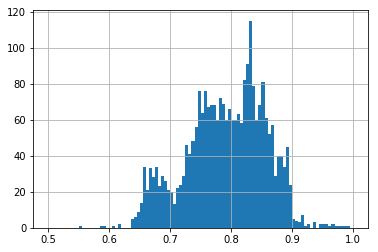

In [13]:
true_b['kumamoto'].b.hist(bins=100, range=(0.5,1))

In [14]:
eq = 'kumamoto'

for eq in sorted(eqs.keys()):

    for GRstats in true_b[eq][['a', 'b', 'mc', 'n', 'radius', 'start_time']].values:

        # a, b, mc, n, radius, start_time = true_b[eq][['a', 'b', 'mc', 'n', 'radius', 'start_time']].values[500]
        a, b, mc, n, radius, start_time = GRstats
        max_n = true_b[eq].n.max()

        if np.isnan(n)==False:

            fmd_data = polygon_selection.get_node_data(node=eqs[eq]['coordinates'], radius=radius, data=catalog, m=1)
            fmd_data = fmd_data[fmd_data.mag >= mc]
            fmd_data = fmd_data[fmd_data.index > start_time]
            fmd_data = fmd_data[fmd_data.index < eqs[eq]['time']]

            hist, edges = np.histogram(a=fmd_data.mag.values, range=(0,10), bins=100)
            chist = np.cumsum(hist[::-1])

            fig, ax = plt.subplots()

            ax.scatter(x=edges[:-1], y=hist, marker='s', edgecolors='black', c='None')
            ax.scatter(x=edges[::-1][:-1], y=chist, marker='^', edgecolors='black', c='red')
            ax.set_yscale('log')
            ax.set_ylim(1e0, 1.5 * max_n)
            ax.set_xlim(0, 10)

            x = np.arange(0, 10, 0.01)
            y = 10**(a - b * x)

            ax.plot(x, y, color='red')
            ax.text(s='r = {r}km\nstart_time = {t}\nb = {b}\nn = {n}\n'.format(r=int(radius)
                                                                        , t=np.datetime64(start_time).astype('datetime64[D]').astype(str)
                                                                       ,b=round(b, 2), n=int(n))
                   ,x=6, y=hist.max())

            # ax.annotate('dfgdfg', xy=(2, 0), xytext=(4, 5))
            ax.annotate('$M_c={mc}$'.format(mc=round(mc,2)), xy=(mc, 1e0), xytext=(mc, 5e0)
                   ,arrowprops=dict(facecolor='black', shrink=0.005
                                   ,width=0.2, headwidth=8))

            ax.set_xlabel('Magnitude')
            ax.set_ylabel('$\log{N}$')
            ax.set_title(eq)
            fig.savefig('grplots/{eq}/{eq}_{st}_{r}.png'.format(eq=eq, st=start_time, r=radius))
            plt.close()
        else:
            pass

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


KeyboardInterrupt: 

In [ ]:
'{y} or {y}'.format(y='yes', n='no')

In [ ]:
for x in true_b[eq][['a', 'b', 'mc', 'n', 'radius', 'start_time']].values:
    print(x)
    break

In [ ]:


fig, ax = plt.subplots(2, 3, figsize=(16,10))
ax = [item for sublist in ax for item in sublist]



eq = 'iwate-miyage'

for eq, axis in zip(true_b, ax):

    avg = true_b[eq][true_b[eq].b.between(0, 2)].b.mean()
    std = true_b[eq][true_b[eq].b.between(0, 2)].b.std()
    distance = 1.0
    vmin = avg - distance * std
    vmax = avg + distance * std


    cbar = plot_radius_time_sweep(dataframe=true_b[eq], vertical_axis='radius'
                           , value='b',vmin=vmin, vmax=vmax, cmap='seismic', fig=fig, ax=axis)

    xticks = np.arange(0,53, 2)
    axis.set_xticks(xticks)
    axis.set_xticklabels((xticks/2).astype(int)[::-1])
    axis.set_xlabel('years before earthquake')

    cbar = fig.colorbar(cbar[2], ticks=[vmin, vmin + 0.5 * std, avg, avg + 0.5 * std, vmax], ax=axis)
    cbar.ax.set_yticklabels(['$-1\sigma$={b}'.format(b=round(vmin,2)), '$-0.5\sigma$'
                             , '$b={b}$'.format(b=round(avg,2)), '$+0.5\sigma$'
                             , '$+1\sigma$={b}'.format(b=round(vmax, 2))])
    
    years_int = true_b[eq].start_time.tail(1).values.astype('datetime64[Y]').astype(int)[0]-20
    
    years = np.arange(1, years_int*2+2, 2)
    axis.set_xticks(years)
    axis.set_xticklabels((years/2).astype(int)[::-1])

    axis.set_title(eq + ' $b_{avg}$'+'$={b}\pm{err}$'.format(b=round(eqs[eq]['average b-value'], 2),
                                              err=round(eqs[eq]['stderr'], 4)))
    
    zi = true_b[eq].pivot(index='start_time', columns='radius', values='n')
    xi_label = [np.datetime64(z, 'Y') for z in zi.index]
    xi = np.arange(len(xi_label))
    yi = zi.columns
    xi, yi = np.meshgrid(xi, yi)

    zi = np.ma.masked_invalid(zi).transpose()

    levels = [10, 50, 250, 1000, 5000]
    cs = axis.contour(xi,yi,zi, levels, colors='yellow')#, locator=ticker.LogLocator())

    cs.levels = ['>10 EQs', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

    axis.clabel(cs, cs.levels, inline=True)
    axis.set_ylim(0,50)
    
fig.tight_layout()


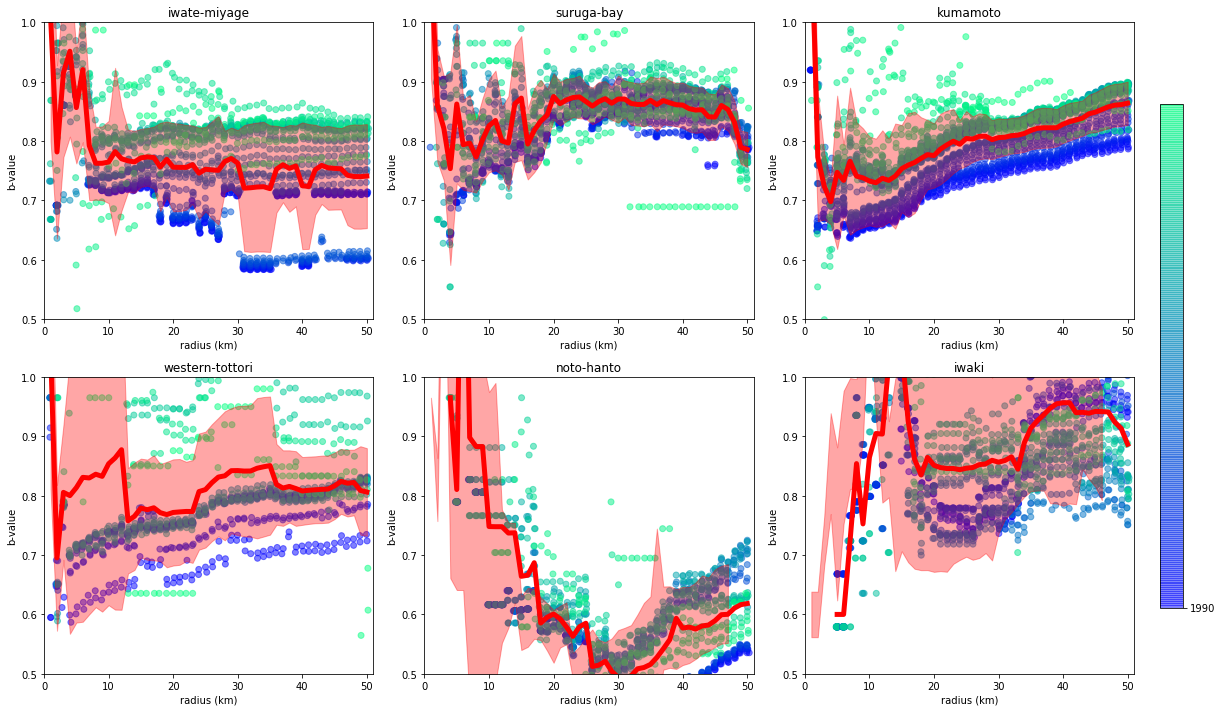

In [15]:
from matplotlib import cm

# df['start_time_int'] = pd.to_datetime(df.start_time).astype('int')
eq = 'kumamoto'
df = true_b[eq]
upper_b = 2.0

fig, ax = plt.subplots(2,3, figsize=(16, 10))

ax = [item for sublist in ax for item in sublist]

for eq, axis in zip(true_b, ax):
    df = true_b[eq].copy()
    # df.plot(kind='scatter', x='radius', y='b_avg', ax=ax, c='start_time_int', cmap='viridis')
    # df.plot(kind='scatter', x=np.random.normal(df['radius'],0.01,df['radius'].shape[0]), y='b')
    cbar = axis.scatter(x=np.random.normal(df['radius'],0.1,df['radius'].shape[0]), y=df['b'].values, alpha=0.5
                ,c=df['start_time'].astype('datetime64[Y]').astype(int), cmap='winter')
    axis.plot(df[df.b < upper_b].groupby('radius').b.mean(), color='red', linewidth=5)

    std = df[df.b < upper_b].groupby('radius').b.std()
    b_avg = df[df.b < upper_b].groupby('radius').b.mean()
    upper = b_avg + std
    lower = b_avg - std

    # b_avg = df[df.b < 1.5].groupby('radius').b.mean()
    # upper = b_avg + df[df.b < 1.5].groupby('radius').b.std()
    # lower = b_avg - df[df.b < 1.5].groupby('radius').b.std()

    axis.fill_between(np.arange(1, lower.shape[0]+1, 1), lower, upper, alpha=0.35, color='red')

    axis.set_ylim(0.5, 1)
    axis.set_xlim(0, 51)
    axis.set_ylabel('b-value')
    axis.set_xlabel('radius (km)')
    axis.set_title(eq)
    
fig.tight_layout()



cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.7])
cb = fig.colorbar(cbar, cax=cbar_ax, ticks=[df['start_time'].astype('datetime64[Y]').astype(int).min()
                                            , df['start_time'].astype('datetime64[Y]').astype(int).max()])
cb.ax.set_yticklabels(['1990', 'Earthquake\nMainshock'])



/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if sys.path[0] == '':


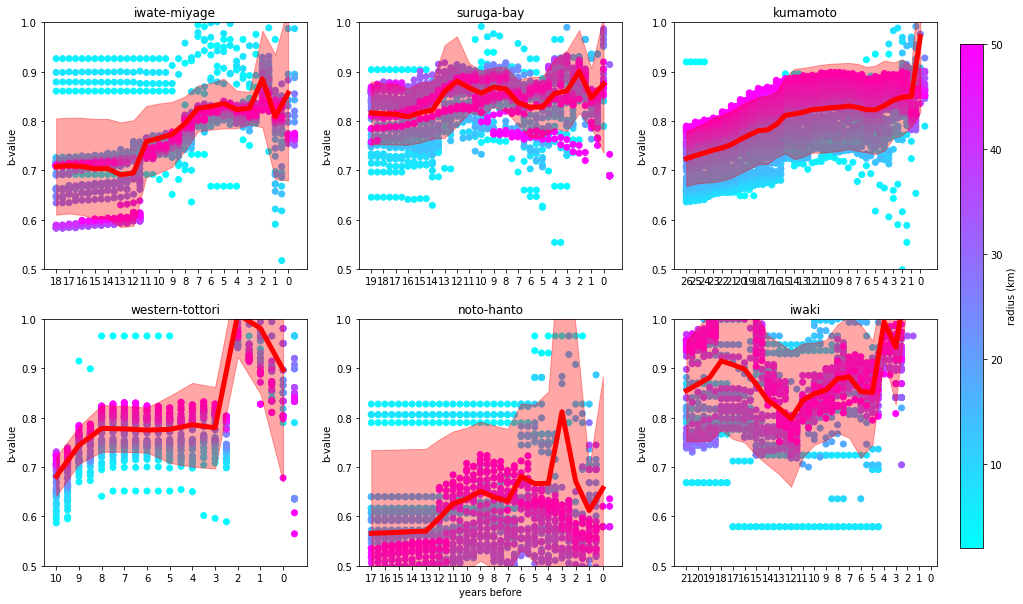

In [16]:
eq = 'kumamoto'
upper_b = 2.0


fig, ax = plt.subplots(2,3, figsize=(16,10))
ax = [item for sublist in ax for item in sublist]

for eq, axis in zip(true_b, ax):

    df = true_b[eq].copy()

    df['years before'] = df['start_time'].values.astype('datetime64[Y]').astype(int) - 20

    x = df['years before'].values.astype(float)
    x[1::2] += 0.5
    y = df['b'].values
    c = df['radius'].values

    b_avg = df[df.b < upper_b].groupby('years before').b.mean()
    b_std = df[df.b < upper_b].groupby('years before').b.std()
    upper = b_avg + b_std
    lower = b_avg - b_std




    cbar = axis.scatter(x=x, y=y, c=c, cmap='cool')

    axis.plot(np.arange(0, b_avg.shape[0]), b_avg, color='red', linewidth=5)
    axis.fill_between(np.arange(0, lower.shape[0], 1), lower, upper, alpha=0.35, color='red')

    axis.set_ylim(0.5, 1)
#     fig.colorbar(cbar, label='radius (km)')
    axis.set_ylabel('b-value')

    axis.set_title(eq)
    axis.set_xticks(df['years before'].unique())
    axis.set_xticklabels(df['years before'].unique()[::-1])
    

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = fig.colorbar(cbar, cax=cbar_ax, label='radius (km)')

ax[4].set_xlabel('years before')

In [ ]:
df['years before'].unique()[::-1]

In [ ]:
x = df['start_time'].values.astype('datetime64[Y]').astype(int) - 20
x = x.astype(float)
x[1::2] += 0.5
x

In [ ]:
df.groupby('radius').b.std()

In [ ]:
print('wtf')

In [ ]:
avg = true_b['kumamoto'].b.mean()
std = true_b['kumamoto'].b.std()

In [ ]:
df.b.hist(bins=100)